# Data Analysis

## Setup

In [1]:
import os
from os.path import join, expanduser
from datetime import datetime

import pandas as pd

import git

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

# For plotting
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, comma_format, percent_format
import plotnine

# plotnine.options.figure_size = (10, 8)
plotnine.options.figure_size = (5, 4)

output_dir = (
    r"C:\Users\WB514197\WBG\Development Data Partnership - Red Sea Maritime Monitoring"
)
charts_dir = join(git_root, "reports")

In [2]:
df = pd.read_parquet(
    join(expanduser("~"), "tmp", "ais", "hormuz", "portcalls_v5.parquet")
)
len(df)

2535792

In [3]:
df.arrival_dt_pos_utc = pd.to_datetime(df.arrival_dt_pos_utc)

In [4]:
df = df.loc[df.arrival_dt_pos_utc >= "2023-02-01"].copy()
df_ref = df.loc[df.arrival_dt_pos_utc < "2023-10-01"].copy()

In [5]:
# df = pd.read_csv(join(expanduser("~"), 'tmp', 'ais', 'G_sea_routes_edges.csv'), index_col=0)
# df.head(10).to_csv(join(expanduser("~"), 'tmp', 'ais', 'G_sea_routes_edges_sample.csv'))

## Get Vessels that crossed Red Sea in Reference Period

In [33]:
aois = ["Bab el-Mandeb Strait", "Suez Canal", "Straight of Hormuz"]

In [36]:
df_sel = df.loc[(df.prev_port.isin(aois)) | (df.Port.isin(aois))].copy()
# df2 = df.loc[(df.prev_port.isin(aois)) | (df.Port.isin(aois))].copy()

In [37]:
unique_vessels_red_sea = list(set(df_sel.unique_id))
unique_vessels = list(set(df.unique_id))
len(unique_vessels_red_sea) / len(unique_vessels)

0.13932403000725982

In [38]:
df2 = df.loc[df.unique_id.isin(unique_vessels_red_sea)].copy()

In [41]:
len(df2) / len(df)

1.0

Select only Cargo and Tanker for reporting

In [11]:
# df2.vessel_type.value_counts()

In [40]:
df2 = df.copy()

In [42]:
types_sel = ["Cargo", "Tanker"]
df2 = df2[df2["vessel_type"].isin(types_sel)].copy()

In [43]:
len(df2) / len(df)

0.7131265483948988

Filter out short trips

In [44]:
df2 = df2.loc[df2.time_travel > 1].copy()

In [45]:
df2.loc[:, "ymd"] = df2.apply(
    lambda x: datetime(year=x["year"], month=x["month"], day=1), axis=1
)

In [46]:
# 1. https://www.ipcc-nggip.iges.or.jp/public/gp/bgp/2_4_Water-borne_Navigation.pdf
# 2. https://iumi.com/images/stories/IUMI/Pictures/Conferences/Genoa2001/Wednesday/05%20statistics%205.pdf

Emissions_Factor = 3212  # (g/kg) - Table 7 (CO2 for US ships, Ocean-going)
Average_Gross_Tonnage = (
    12042  # Gigaton - Average gross weight tonnage for cargo in 2000, from link 2
)
Fuel_Consumption = 9.8197 + (
    0.00143 * Average_Gross_Tonnage
)  # (Mg/day) - Fuel consumption factor from Table 13 (general cargo)
days = 1  # This parameter will change depending on time traveled
Fuel_Consumption_Total = Fuel_Consumption * days
# Result is in micrograms per day, does it need to be converted to kg to multiply by emissions factor?
Fuel_Consumption_Total_kg = Fuel_Consumption_Total * 1000  # Kg per day
# convert megagrams to kilograms

# If so, results in a very small number, otherwise...
Emissions = Emissions_Factor * Fuel_Consumption_Total_kg
Emissions

86851709.12

In [47]:
def get_emissions(row):
    Fuel_Consumption_Total = Fuel_Consumption * row["days_travel2"]
    Fuel_Consumption_Total_kg = Fuel_Consumption_Total * 1000
    Emissions = Emissions_Factor * Fuel_Consumption_Total_kg
    Emissions_mt = Emissions / 1000000
    return Emissions_mt

In [48]:
df2["time_travel2"] = pd.to_timedelta(df["time_travel"], unit="H")

In [49]:
df2.loc[:, "days_travel2"] = df["time_travel"] / 24

In [50]:
df2.loc[:, "emissions"] = df2.apply(lambda x: get_emissions(x), axis=1)

In [53]:
group_cols = ["ymd", "vessel_type"]
data_cols = ["time_travel", "distance", "emissions", "days_travel2"]
df_horm = df2.loc[
    (df2.Port == "Straight of Hormuz") | (df2.prev_port == "Straight of Hormuz")
].copy()
df_agg_horm = df_horm.groupby(group_cols)[data_cols].sum().reset_index()

In [55]:
p4 = (
    ggplot(df_agg_horm, aes(x="ymd", y="distance", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="",
        subtitle="Distance (nautical miles)",
        fill="Vessel Type",
        title="Total Distance Traveled by all Vessels, Straight of Hormuz",
        # caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have crossed the Cape of Good Hope",
    )
    + theme_minimal()
    + scale_y_continuous(labels=comma_format())
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + theme(
        text=element_text(family="Roboto", size=13),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="right",
    )
)
# display(p4)
p4.save(filename=join(charts_dir, "routes", "distance-traveled-horm-all.jpeg"), dpi=300)

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\distance-traveled-horm-all.jpeg


In [21]:
df_cape = df2.loc[
    (df2.Port == "Cape of Good Hope") | (df2.prev_port == "Cape of Good Hope")
].copy()
df_bab = df2.loc[
    (df2.Port == "Bab el-Mandeb Strait") | (df2.prev_port == "Bab el-Mandeb Strait")
].copy()
df_horm = df2.loc[
    (df2.Port == "Straight of Hormuz") | (df2.prev_port == "Straight of Hormuz")
].copy()
df3 = pd.concat([df_cape, df_bab])
df3.reset_index(drop=False, inplace=True)
df3 = df3.loc[~df3.duplicated(subset="index")].copy()
group_cols = ["ymd", "vessel_type"]
data_cols = ["time_travel", "distance", "emissions", "days_travel2"]
df_agg = df3.groupby(group_cols)[data_cols].sum().reset_index()
df_agg_cape = df_cape.groupby(group_cols)[data_cols].sum().reset_index()
df_agg_bab = df_bab.groupby(group_cols)[data_cols].sum().reset_index()
df_agg_horm = df_horm.groupby(group_cols)[data_cols].sum().reset_index()

In [22]:
# plotnine.options.figure_size = (10, 8)
# plotnine.options.figure_size = (5, 4)
plotnine.options.figure_size = (8, 6)

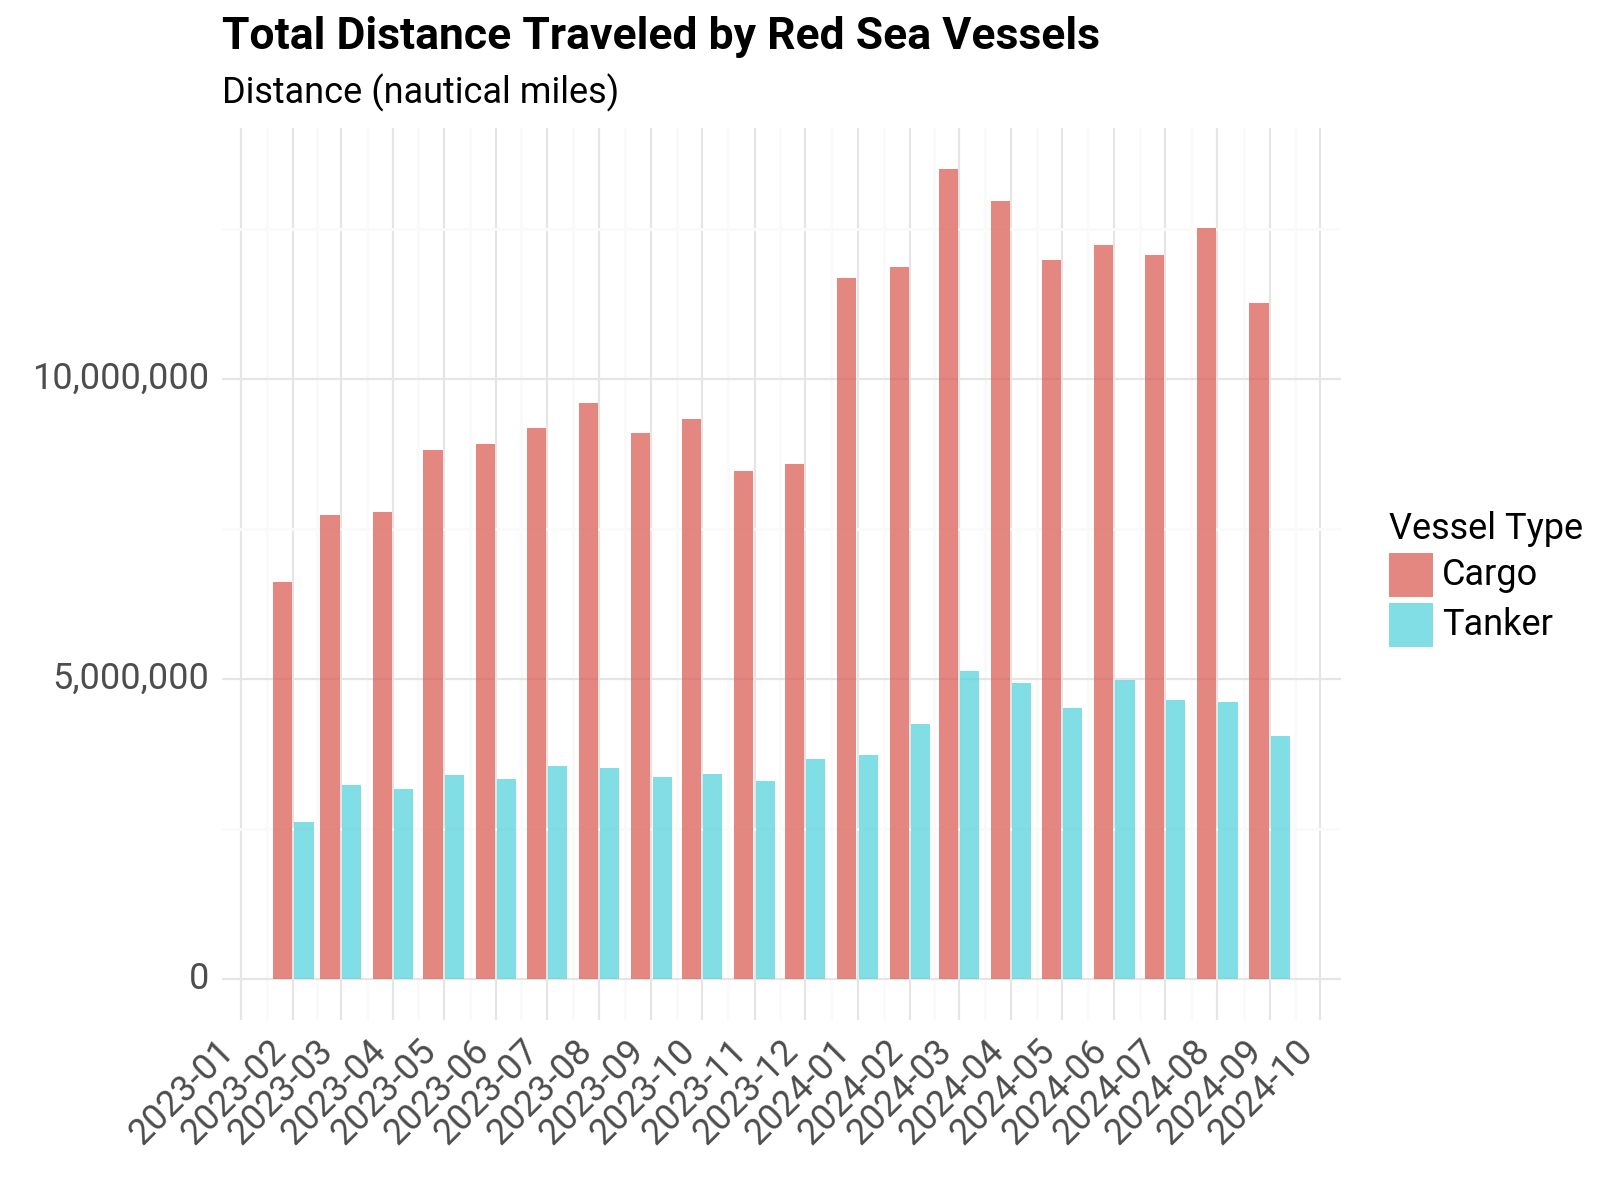

<Figure Size: (800 x 600)>

In [23]:
p0 = (
    ggplot(df_agg, aes(x="ymd", y="distance", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="",
        subtitle="Distance (nautical miles)",
        title="Total Distance Traveled by Red Sea Vessels",
        # caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have either crossed the Bab el-Mandeb Strait or the Cape of Good Hope in the period of interest.",
        fill="Vessel Type",
    )
    + theme_minimal()
    + scale_y_continuous(labels=comma_format())
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + theme(
        text=element_text(family="Roboto", size=13),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="right",
    )
)
display(p0)
# p0.save(filename=join(charts_dir, "routes", "distance-traveled.jpeg"), dpi=300)

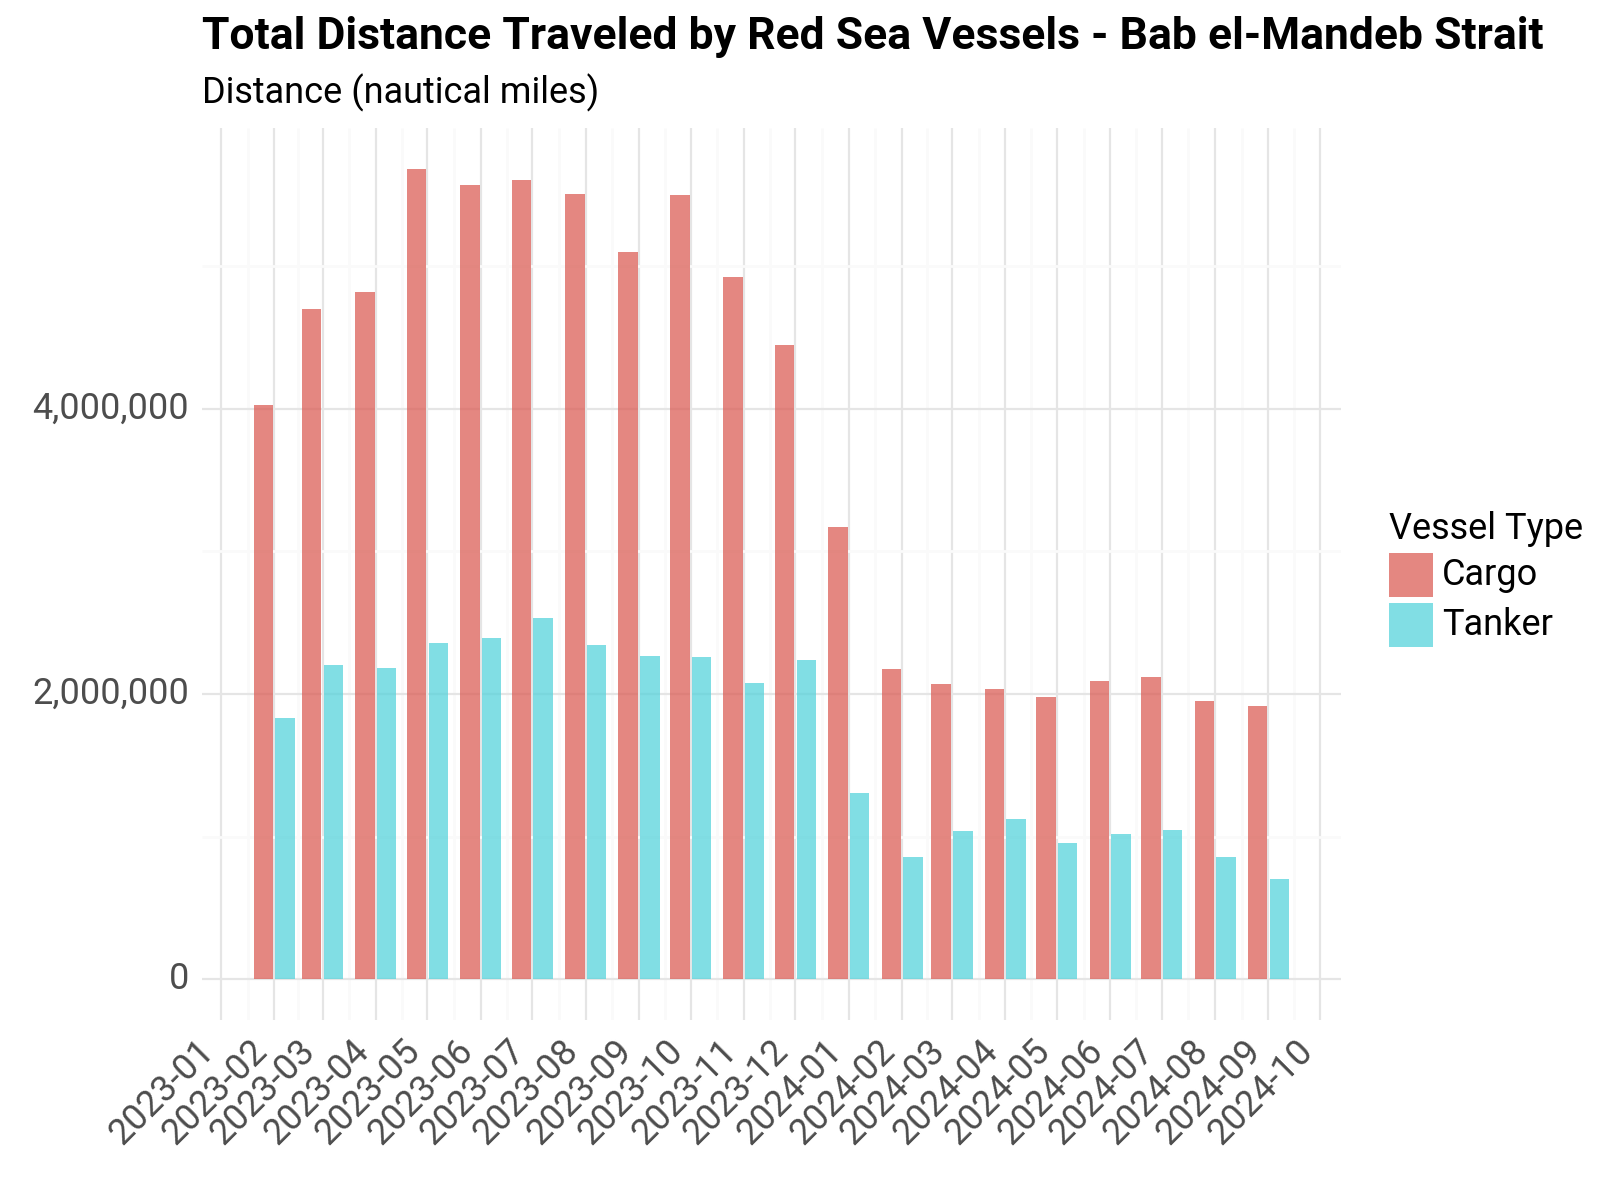

<Figure Size: (800 x 600)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\distance-traveled-bab.jpeg


In [27]:
p1 = (
    ggplot(df_agg_bab, aes(x="ymd", y="distance", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="",
        subtitle="Distance (nautical miles)",
        fill="Vessel Type",
        title="Total Distance Traveled by Red Sea Vessels - Bab el-Mandeb Strait",
        # caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have crossed the Bab el-Mandeb Strait",
    )
    + theme_minimal()
    + scale_y_continuous(labels=comma_format())
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + theme(
        text=element_text(family="Roboto", size=13),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="right",
    )
)
display(p1)
p1.save(filename=join(charts_dir, "routes", "distance-traveled-bab.jpeg"), dpi=300)

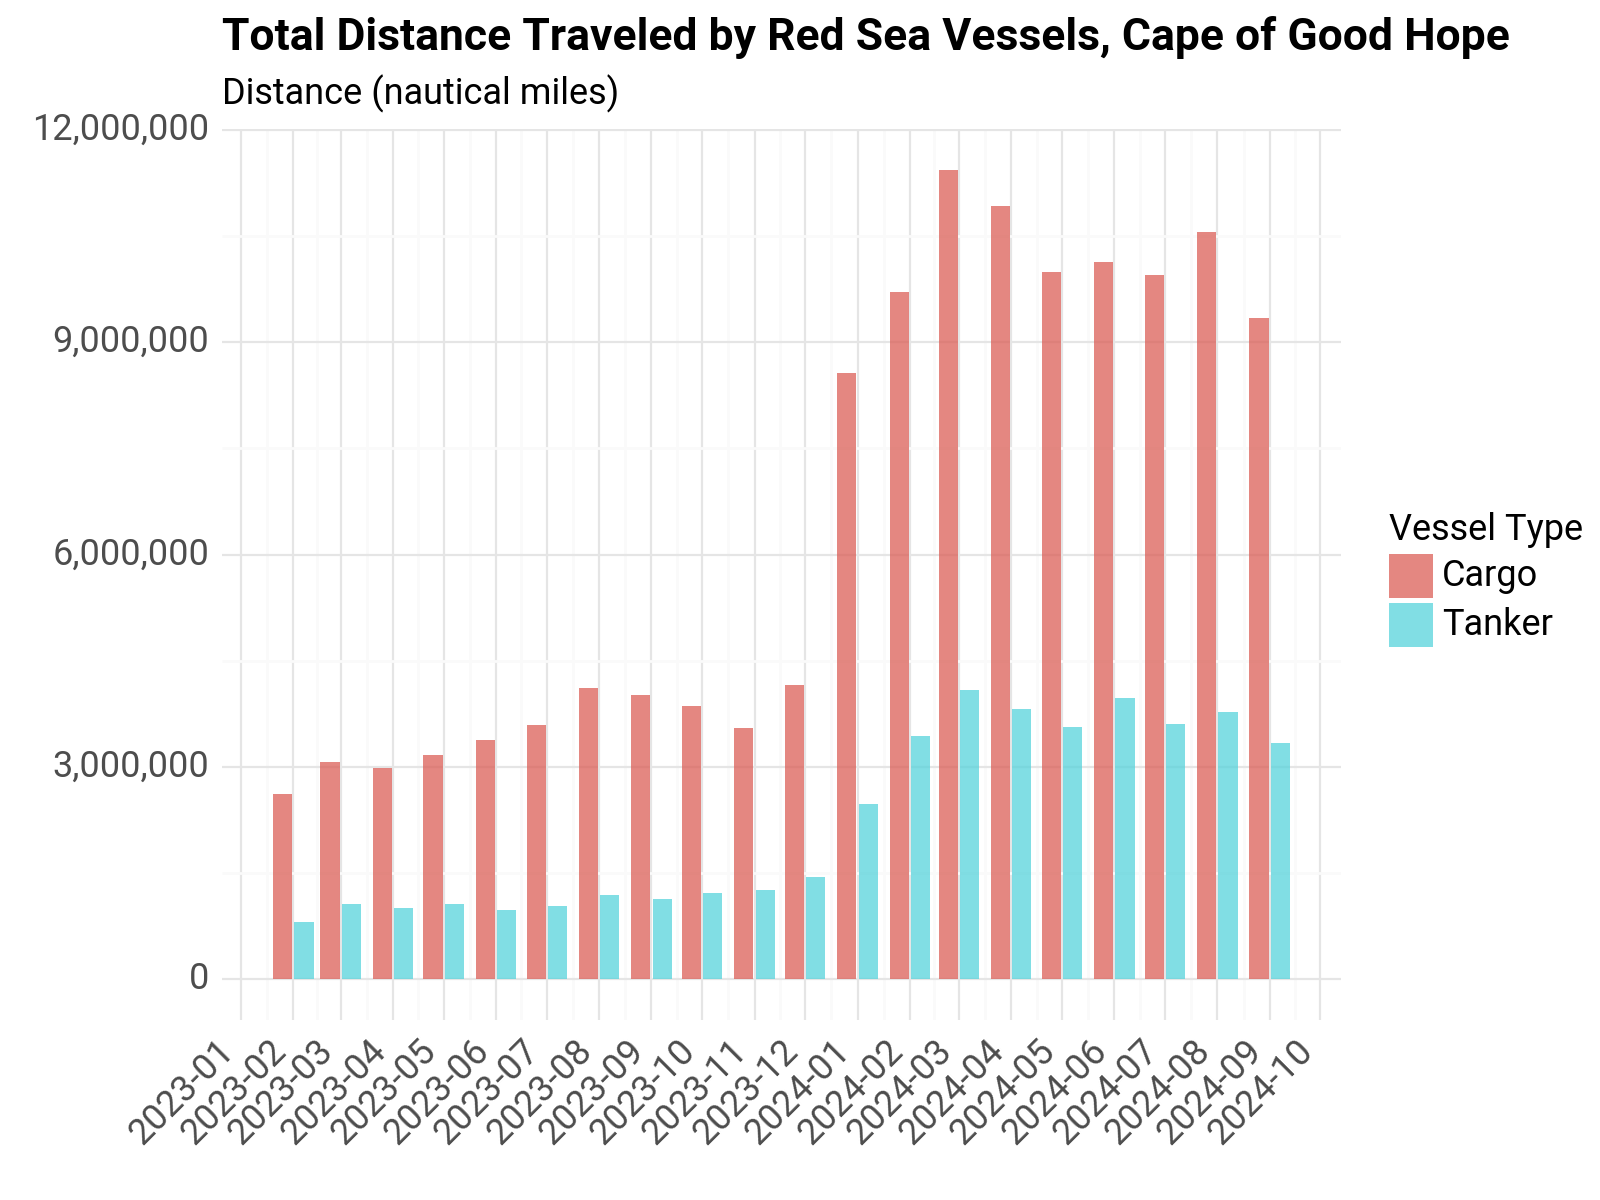

<Figure Size: (800 x 600)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\distance-traveled-cape.jpeg


In [29]:
p3 = (
    ggplot(df_agg_cape, aes(x="ymd", y="distance", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="",
        subtitle="Distance (nautical miles)",
        fill="Vessel Type",
        title="Total Distance Traveled by Red Sea Vessels, Cape of Good Hope",
        # caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have crossed the Cape of Good Hope",
    )
    + theme_minimal()
    + scale_y_continuous(labels=comma_format())
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + theme(
        text=element_text(family="Roboto", size=13),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="right",
    )
)
display(p3)
p3.save(filename=join(charts_dir, "routes", "distance-traveled-cape.jpeg"), dpi=300)

In [32]:
p4 = (
    ggplot(df_agg_horm, aes(x="ymd", y="distance", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="",
        subtitle="Distance (nautical miles)",
        fill="Vessel Type",
        title="Total Distance Traveled by Red Sea Vessels, Straight of Hormuz",
        # caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have crossed the Cape of Good Hope",
    )
    + theme_minimal()
    + scale_y_continuous(labels=comma_format())
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + theme(
        text=element_text(family="Roboto", size=13),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="right",
    )
)
# display(p4)
p4.save(filename=join(charts_dir, "routes", "distance-traveled-horm.jpeg"), dpi=300)

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\distance-traveled-horm.jpeg


In [28]:
charts_dir

'C:/Users/WB514197/Repos/red-sea-monitoring\\reports'

In [32]:
p0 = (
    ggplot(df_agg, aes(x="ymd", y="emissions", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="",
        subtitle="Metric Tons",
        title="CO2 Emissions, Red Sea Vessels",
        # caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have either crossed the Bab el-Mandeb Strait or the Cape of Good Hope in the period of interest.",
        fill="Vessel Type",
    )
    + theme_minimal()
    # + scale_y_continuous(labels=metric_tons_formatter)
    + scale_y_continuous(labels=comma_format())
    # + scale_y_continuous(labels = unit_format(unit = "M", scale = 1e-6))
    + scale_x_datetime(breaks=date_breaks("2 month"), labels=date_format("%Y-%m"))
    + theme(
        text=element_text(family="Roboto", size=12),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45),  # , hjust=1
        legend_position="bottom",
    )
)
# display(p0)
p0.save(filename=join(charts_dir, "routes", "emissions-red-sea.jpeg"), dpi=300)

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\emissions-red-sea.jpeg


In [31]:
p0 = (
    ggplot(df_agg_cape, aes(x="ymd", y="emissions", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="",
        subtitle="Metric Tons",
        title="CO2 Emissions, Red Sea Vessels Crossing Cape of Good Hope",
        # caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have either crossed the Bab el-Mandeb Strait or the Cape of Good Hope in the period of interest.",
        fill="Vessel Type",
    )
    + theme_minimal()
    # + scale_y_continuous(labels=metric_tons_formatter)
    + scale_y_continuous(labels=comma_format())
    # + scale_y_continuous(labels = unit_format(unit = "M", scale = 1e-6))
    + scale_x_datetime(breaks=date_breaks("2 month"), labels=date_format("%Y-%m"))
    + theme(
        text=element_text(family="Roboto", size=12),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45),  # , hjust=1
        legend_position="bottom",
    )
)
# display(p0)
p0.save(filename=join(charts_dir, "routes", "emissions-cape.jpeg"), dpi=300)

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\emissions-cape.jpeg


## Data Table

In [27]:
group_cols = [
    "year",
    "month",
    "vessel_type",
    "Country",
    "Port",
    "prev_country",
    "prev_port",
]
data_cols = ["time_travel", "distance"]
df_agg_od = (
    df3.groupby(group_cols)
    .aggregate({"time_travel": "sum", "distance": "sum", "unique_id": "count"})
    .reset_index()
)
df_agg_od.rename(
    columns={
        "unique_id": "No. of Vessels",
        "prev_port": "Previous Port",
        "prev_country": "Previous Country",
        "vessel_type": "Vessel Type",
        "time_travel": "Total travel time (hrs.)",
        "distance": "Total distance (n. miles)",
        "count_routes": "No. of Vessels",
    },
    inplace=True,
)
df_agg_od = df_agg_od[
    [
        "year",
        "month",
        "Vessel Type",
        "Previous Port",
        "Previous Country",
        "Country",
        "Port",
        "Total travel time (hrs.)",
        "Total distance (n. miles)",
        "No. of Vessels",
    ]
].copy()

In [28]:
df_agg_od.head()

,year,month,Vessel Type,Previous Port,Previous Country,Country,Port,Total travel time (hrs.),Total distance (n. miles),No. of Vessels
0,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Angola,Luanda,338.479167,4844.855522,3
1,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Argentina,Campana,1284.538333,7714.825095,2
2,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Argentina,Puerto Ingeniero White,435.671389,4088.880729,1
3,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Argentina,Rosario,2431.078889,23688.201240,6
4,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Argentina,San Nicolas,915.360000,7878.375107,2


In [29]:
print(df_agg_od.head().to_markdown())

|    |   year |   month | Vessel Type   | Previous Port     | Previous Country             | Country   | Port                   |   Total travel time (hrs.) |   Total distance (n. miles) |   No. of Vessels |
|---:|-------:|--------:|:--------------|:------------------|:-----------------------------|:----------|:-----------------------|---------------------------:|----------------------------:|-----------------:|
|  0 |   2023 |       2 | Cargo         | Cape of Good Hope | Chokepoint Cape of Good Hope | Angola    | Luanda                 |                    338.479 |                     4844.86 |                3 |
|  1 |   2023 |       2 | Cargo         | Cape of Good Hope | Chokepoint Cape of Good Hope | Argentina | Campana                |                   1284.54  |                     7714.83 |                2 |
|  2 |   2023 |       2 | Cargo         | Cape of Good Hope | Chokepoint Cape of Good Hope | Argentina | Puerto Ingeniero White |                    435.671 |          

In [32]:
df_agg_od.to_csv(
    join(output_dir, "tables", "red-sea-distance-summary-10-03-2024.csv"), index=False
)

## Calculate % Change from Baseline

In [33]:
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

In [34]:
df_baseline = df_agg.loc[df_agg.ymd < "2023-10-01"].copy()

In [35]:
df_baseline = df_baseline.groupby(["vessel_type"])[["time_travel", "distance"]].mean()

In [36]:
df_baseline.reset_index(inplace=True)

In [37]:
df_baseline.rename(
    columns={"time_travel": "time_travel_ref", "distance": "distance_ref"}, inplace=True
)

In [38]:
df_crisis = df_agg.loc[df_agg.ymd >= "2023-10-01"].copy()

In [39]:
df_crisis = df_crisis.merge(df_baseline, on="vessel_type", how="left")

In [40]:
df_crisis.loc[:, "distance_pct"] = (
    df_crisis.distance - df_crisis.distance_ref
) / df_crisis.distance_ref
df_crisis.loc[:, "time_pct"] = (
    df_crisis.time_travel - df_crisis.time_travel_ref
) / df_crisis.time_travel_ref

In [41]:
# df_crisis = df_crisis.loc[df_crisis.ymd>='2024-01-01'].copy()

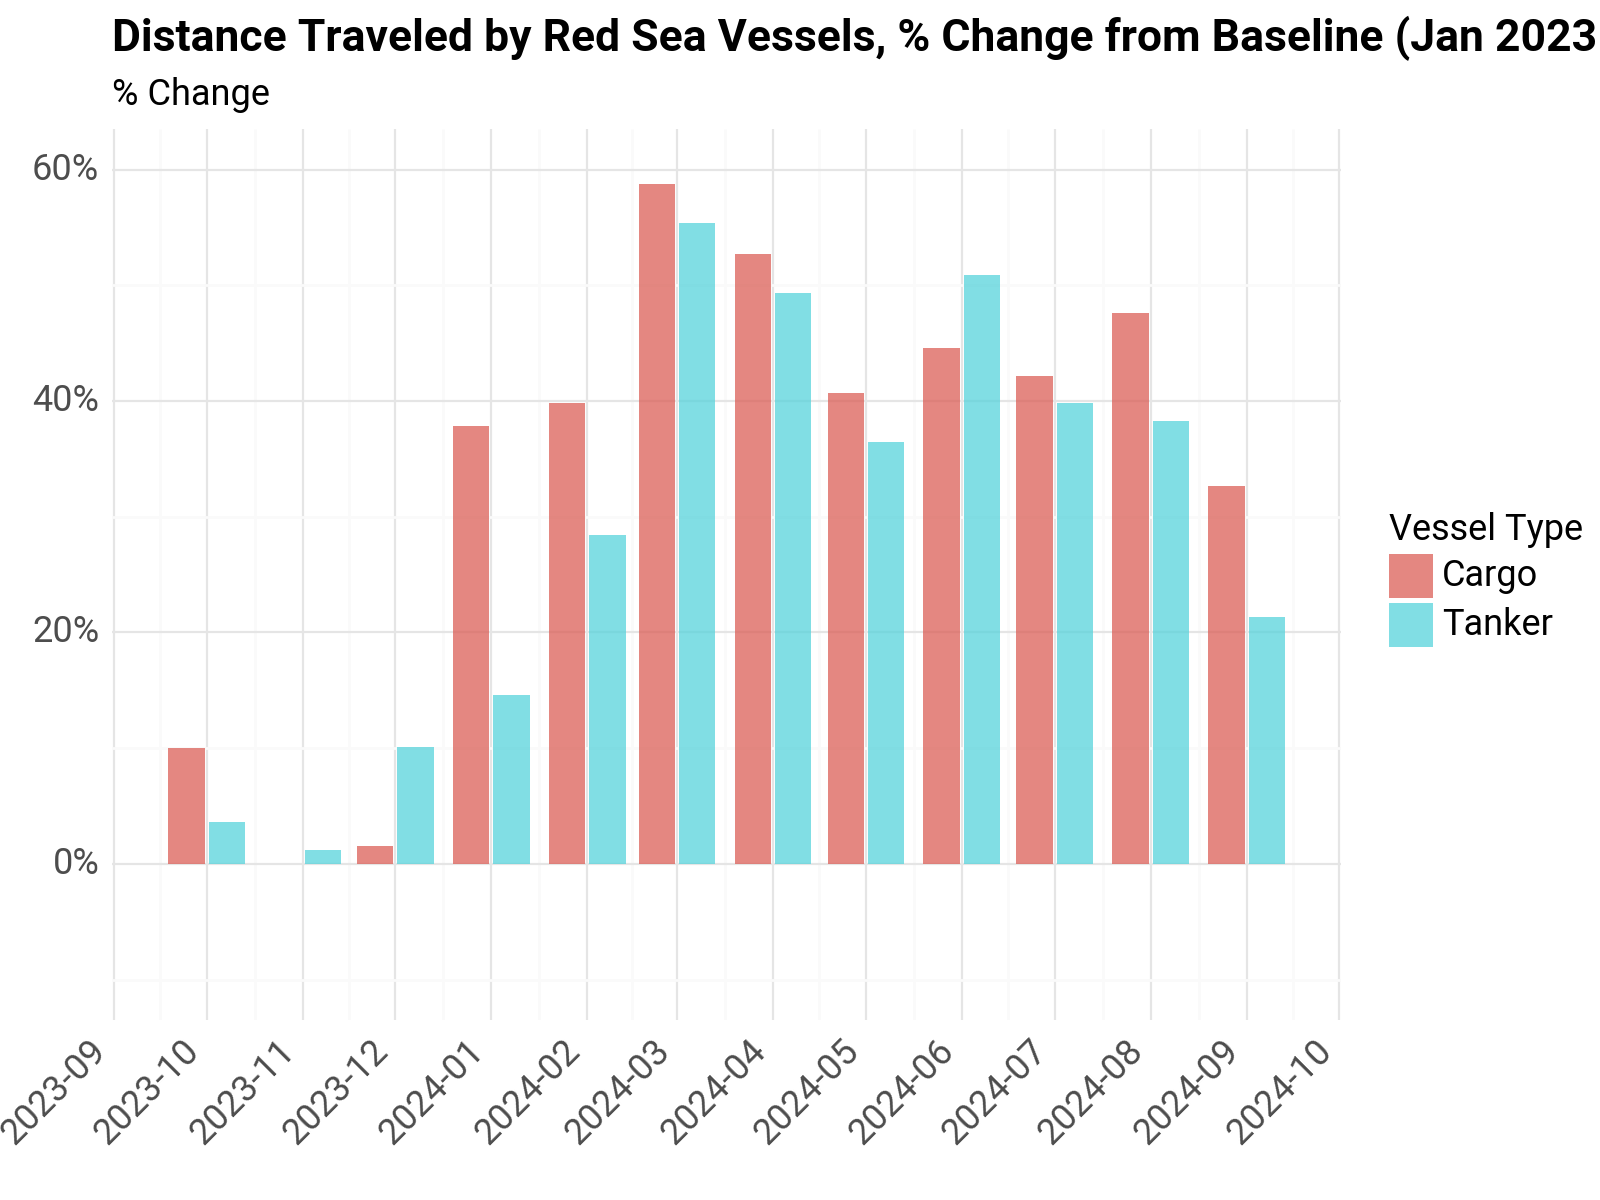

<Figure Size: (800 x 600)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\distance-traveled-pct.jpeg


In [42]:
p4 = (
    ggplot(df_crisis, aes(x="ymd", y="distance_pct", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="",
        subtitle="% Change",
        fill="Vessel Type",
        title="Distance Traveled by Red Sea Vessels, % Change from Baseline (Jan 2023 - Sep 2023)",
        # caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have crossed the Cape of Good Hope",
    )
    + theme_minimal()
    + scale_y_continuous(labels=percent_format(), limits=(-0.1, 0.6))
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + theme(
        text=element_text(family="Roboto", size=13),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="right",
    )
)
display(p4)
p4.save(filename=join(charts_dir, "routes", "distance-traveled-pct.jpeg"), dpi=300)

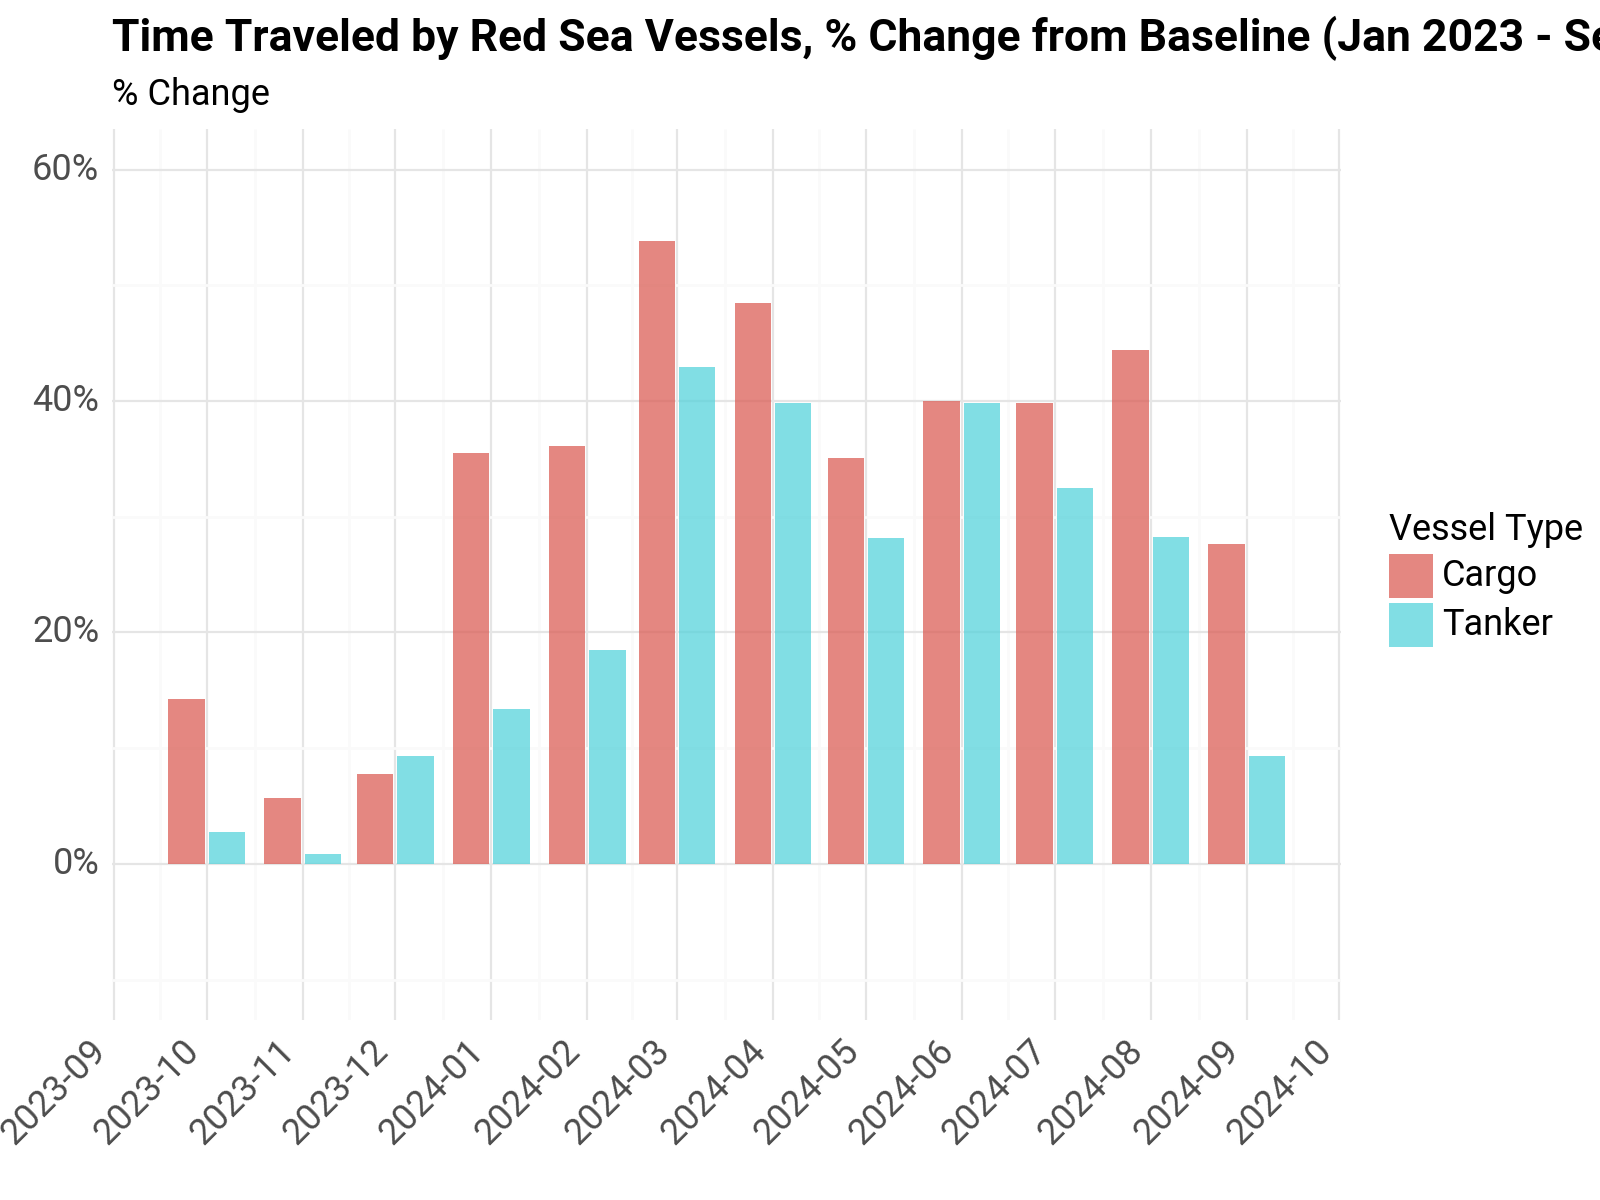

<Figure Size: (800 x 600)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\time-traveled-pct.jpeg


In [43]:
p5 = (
    ggplot(df_crisis, aes(x="ymd", y="time_pct", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="",
        subtitle="% Change",
        fill="Vessel Type",
        title="Time Traveled by Red Sea Vessels, % Change from Baseline (Jan 2023 - Sep 2023)",
        # caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have crossed the Cape of Good Hope",
    )
    + theme_minimal()
    + scale_y_continuous(labels=percent_format(), limits=(-0.1, 0.6))
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + theme(
        text=element_text(family="Roboto", size=13),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="right",
    )
)
display(p5)
p5.save(filename=join(charts_dir, "routes", "time-traveled-pct.jpeg"), dpi=300)

In [44]:
df_crisis_sel = df_crisis.loc[df_crisis.ymd >= "2024-01-01"].copy()

In [45]:
df_crisis_sel.ymd

6    2024-01-01
7    2024-01-01
8    2024-02-01
9    2024-02-01
10   2024-03-01
11   2024-03-01
12   2024-04-01
13   2024-04-01
14   2024-05-01
15   2024-05-01
16   2024-06-01
17   2024-06-01
18   2024-07-01
19   2024-07-01
20   2024-08-01
21   2024-08-01
22   2024-09-01
23   2024-09-01
Name: ymd, dtype: datetime64[ns]

In [46]:
df_crisis_sel.loc[:, "year_month"] = df_crisis_sel.ymd.dt.strftime("%Y-%m")

In [47]:
pct_table = df_crisis_sel.groupby(["year_month", "vessel_type"])[
    ["distance_pct", "time_pct"]
].mean()  # .transpose()

In [48]:
pct_table.reset_index(inplace=True)

In [56]:
cargo_table = pct_table.loc[pct_table.vessel_type == "Cargo"].copy()
tanker_table = pct_table.loc[pct_table.vessel_type == "Tanker"].copy()

cargo_table.drop(columns=["vessel_type"], inplace=True)
tanker_table.drop(columns=["vessel_type"], inplace=True)

In [57]:
cargo_table.set_index("year_month", inplace=True)
tanker_table.set_index("year_month", inplace=True)

cargo_table = cargo_table.transpose()
tanker_table = tanker_table.transpose()

In [58]:
cargo_table.index = ["% Change Distance Travel", "% Change Time Travel"]
tanker_table.index = ["% Change Distance Travel", "% Change Time Travel"]

In [59]:
cargo_table = cargo_table.applymap(lambda x: f"{x:.1%}")
tanker_table = tanker_table.applymap(lambda x: f"{x:.1%}")

C:\Users\WB514197\AppData\Local\Temp\ipykernel_12956\1012980847.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
C:\Users\WB514197\AppData\Local\Temp\ipykernel_12956\1012980847.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [60]:
print(cargo_table.to_markdown())

|                          | 2024-01   | 2024-02   | 2024-03   | 2024-04   | 2024-05   | 2024-06   | 2024-07   | 2024-08   | 2024-09   |
|:-------------------------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|
| % Change Distance Travel | 37.8%     | 39.8%     | 58.8%     | 52.7%     | 40.7%     | 44.6%     | 42.2%     | 47.6%     | 32.7%     |
| % Change Time Travel     | 35.5%     | 36.1%     | 53.8%     | 48.5%     | 35.1%     | 40.0%     | 39.8%     | 44.4%     | 27.7%     |


In [61]:
print(tanker_table.to_markdown())

|                          | 2024-01   | 2024-02   | 2024-03   | 2024-04   | 2024-05   | 2024-06   | 2024-07   | 2024-08   | 2024-09   |
|:-------------------------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|
| % Change Distance Travel | 14.6%     | 28.4%     | 55.4%     | 49.4%     | 36.5%     | 50.9%     | 39.8%     | 38.2%     | 21.3%     |
| % Change Time Travel     | 13.4%     | 18.5%     | 43.0%     | 39.8%     | 28.1%     | 39.9%     | 32.4%     | 28.3%     | 9.4%      |


## OECD Data

In [62]:
# df = pd.read_csv(join(expanduser("~"), 'tmp', 'ais', 'OECD.SDD.NAD.SEEA,DSD_MARITIME_TRANSPORT@DF_MARITIME_TRANSPORT,1.0+all.csv'))
df = pd.read_csv(
    join(
        expanduser("~"),
        "tmp",
        "ais",
        "OECD.SDD.NAD.SEEA,DSD_MARITIME_TRANSPORT@DF_MARITIME_TRANSPORT,1.0+.M.EMISSIONS.....ALL_VESSELS_10-03-2024.csv",
    )
)  # latest

In [63]:
df.Vessel.value_counts()

Vessel
All vessels    3423
Name: count, dtype: int64

In [64]:
df = df.loc[df.FREQ == "M"].copy()

In [65]:
drop_areas = ["W", "OECD", "W_O"]
df = df.loc[~df.REF_AREA.isin(drop_areas)].copy()

In [66]:
df = df[["TIME_PERIOD", "OBS_VALUE", "REF_AREA", "Vessel"]].copy()

In [67]:
df.loc[:, "ymd"] = pd.to_datetime(df["TIME_PERIOD"])

In [68]:
df = df.loc[df.ymd > "2022-01-01"].copy()

In [69]:
df.groupby("REF_AREA").size()

REF_AREA
AGO    29
ALB    29
ARE    29
ARG    29
ATG    15
       ..
VIR    18
VNM    29
VUT    29
WSM    29
ZAF    29
Length: 116, dtype: int64

In [70]:
df = df.groupby(["TIME_PERIOD", "ymd"])["OBS_VALUE"].sum().reset_index().copy()

In [71]:
df.loc[:, "year_month"] = df.ymd.dt.strftime("%Y-%m")

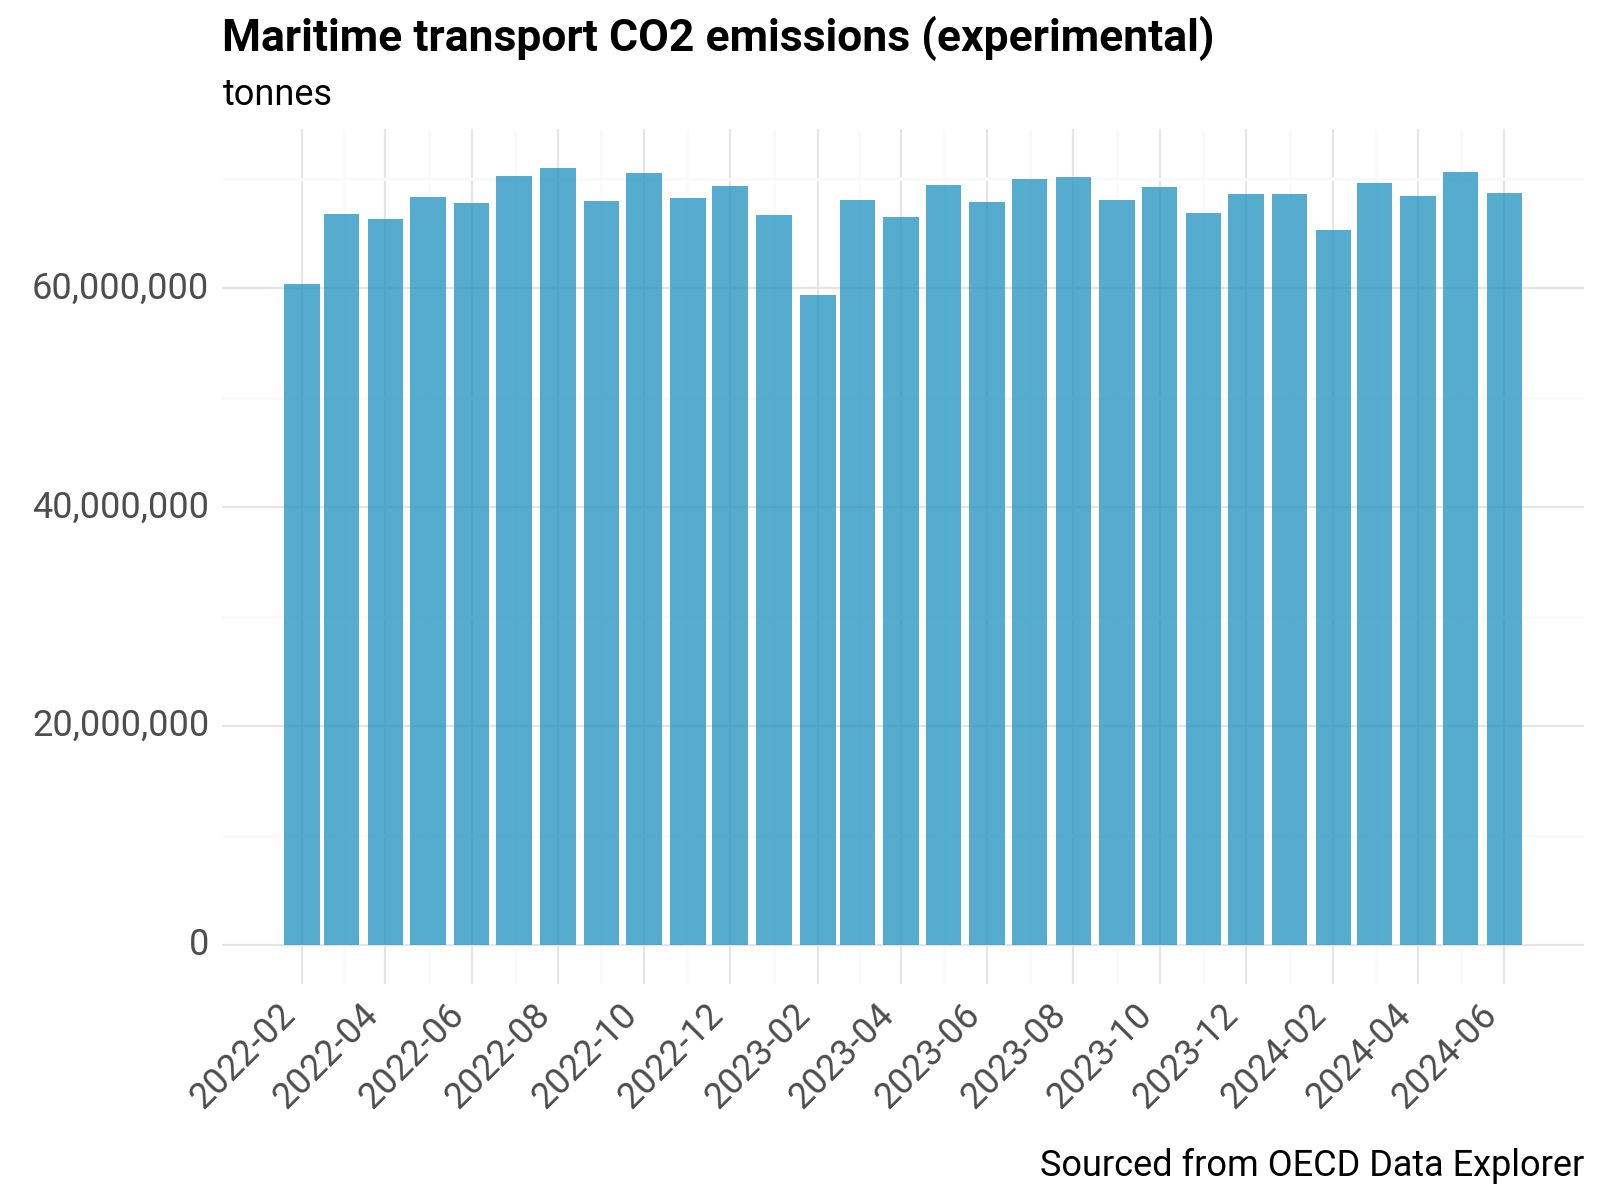

<Figure Size: (800 x 600)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\oecd-historical.jpeg


In [72]:
p0 = (
    ggplot(df, aes(x="ymd", y="OBS_VALUE"))  #
    + geom_bar(alpha=3 / 4, stat="identity", fill="#1d91c0")
    + labs(
        x="",
        y="",
        subtitle="tonnes",
        title="Maritime transport CO2 emissions (experimental)",
        caption="Sourced from OECD Data Explorer",
    )
    + theme_minimal()
    + scale_y_continuous(labels=comma_format())
    + scale_x_datetime(breaks=date_breaks("2 month"), labels=date_format("%Y-%m"))
    + theme(
        text=element_text(family="Roboto", size=13),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="none",
    )
)
display(p0)
p0.save(filename=join(charts_dir, "routes", "oecd-historical.jpeg"), dpi=300)

In [73]:
df_filt = df.loc[df.ymd > "2023-01-01"].copy()

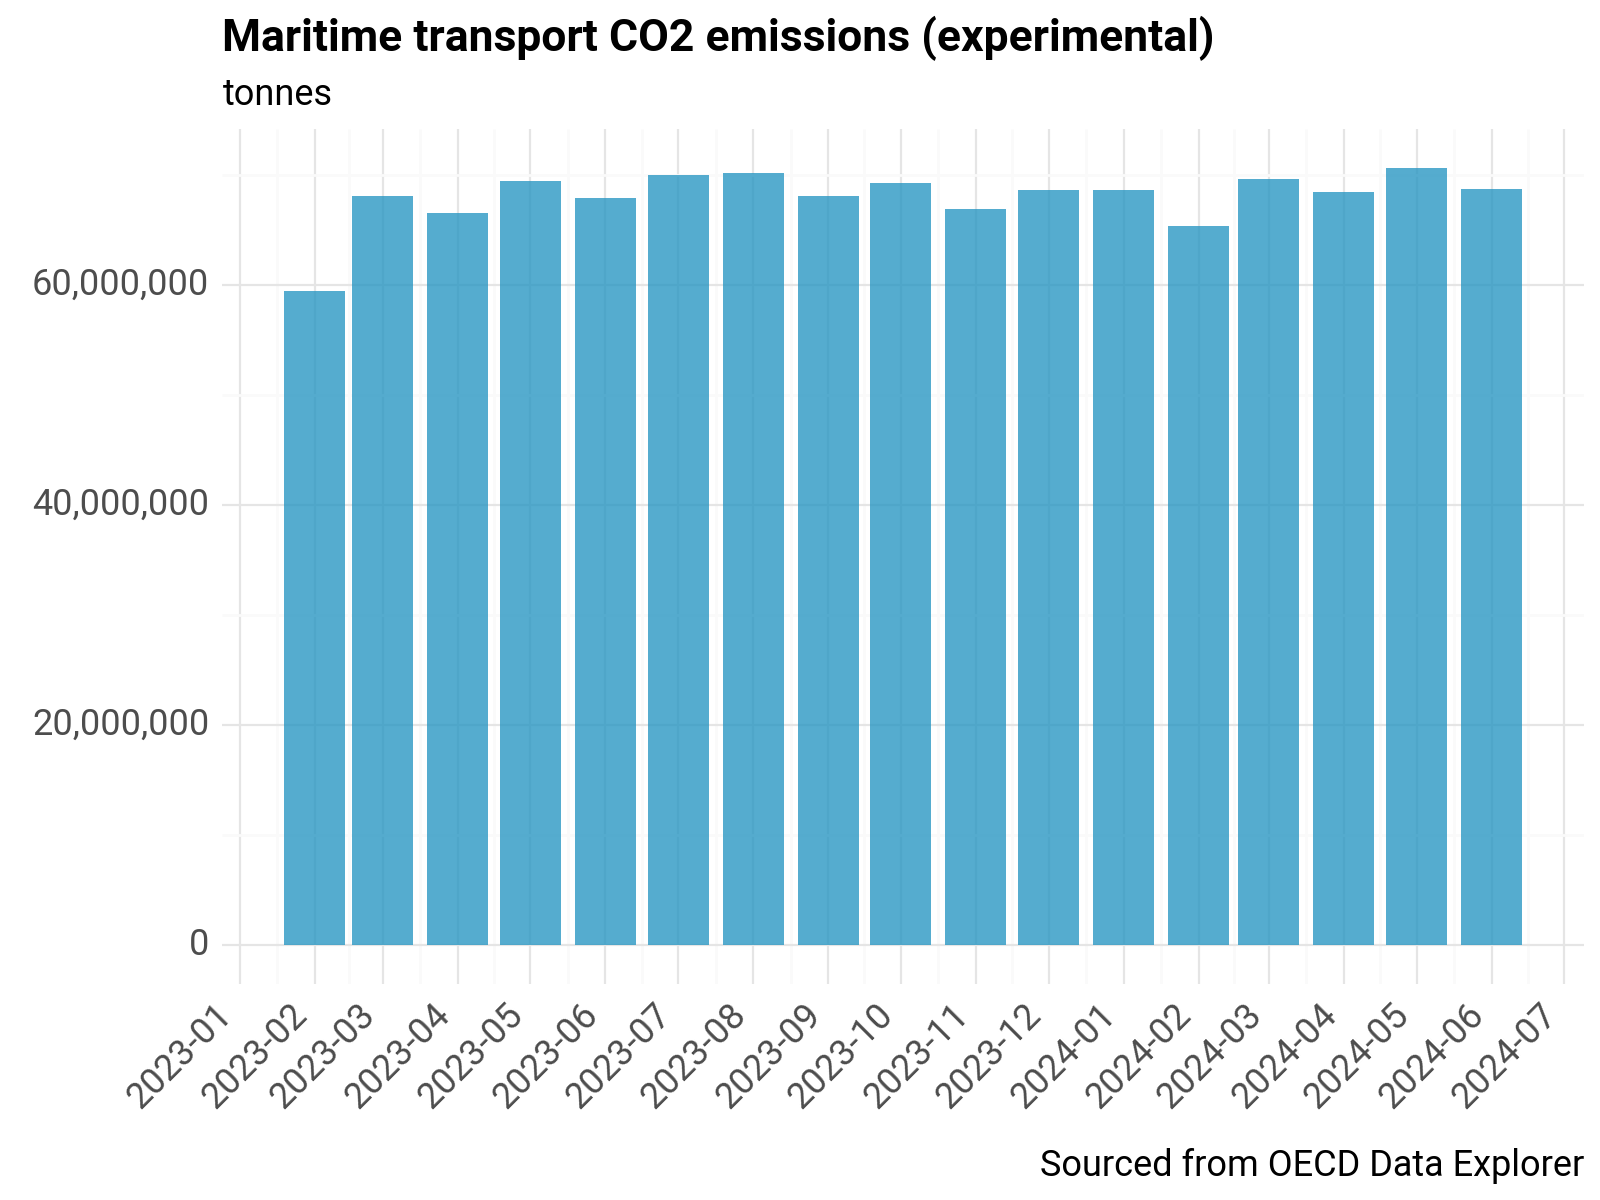

<Figure Size: (800 x 600)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\oecd.jpeg


In [74]:
p0 = (
    ggplot(df_filt, aes(x="ymd", y="OBS_VALUE"))  #
    + geom_bar(alpha=3 / 4, stat="identity", fill="#1d91c0")
    + labs(
        x="",
        y="",
        subtitle="tonnes",
        title="Maritime transport CO2 emissions (experimental)",
        caption="Sourced from OECD Data Explorer",
    )
    + theme_minimal()
    + scale_y_continuous(labels=comma_format())
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + theme(
        text=element_text(family="Roboto", size=13),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="none",
    )
)
display(p0)
p0.save(filename=join(charts_dir, "routes", "oecd.jpeg"), dpi=300)